In [1]:
import numpy as np
#from numba import jit
from pylidar import lidarprocessor
from pylidar.toolbox import spatial
from pylidar.lidarformats import pulsewaves
from pylidar.lidarformats import generic
from pylidar import userclasses as uc
from matplotlib import pyplot as plt
#import pickle
import time

In [2]:
## here are some processing functions:
# readChunk() reads the data chunk by chunk
# appendChunk() appends each chunk to a list

# define a function to append the chunk
# @jit doesnt help here
def appendChunk(otherArgs):
    
    otherArgs.allWaveInfo.append(otherArgs.waveinfo)
    otherArgs.allRecv.append(otherArgs.recv)
    otherArgs.allTrans.append(otherArgs.trans)
    otherArgs.allPulses.append(otherArgs.pulses)
    

# define a function to read the data
def readChunk(data, otherArgs):
    # returns 2d masked structured array with info about waveforms
    # first axis is waveform number, second is pulse
    #waveinfo = data.input1.getWaveformInfo()
    otherArgs.waveinfo = data.input1.getWaveformInfo()
    
    # returns masked 3d radiance array
    # first axis is waveform bin, second is waveform number, third is pulse
    otherArgs.recv = data.input1.getReceived()
    otherArgs.trans = data.input1.getTransmitted()
    otherArgs.pulses = data.input1.getPulses()
    
    
    # call the append function
    appendChunk(otherArgs)


In [3]:
inFile = r"C:\Projects\RD\NEON_data\NIWO\waveform\riegl\thinned.pls"

# get some information about the file
pw_info = pulsewaves.PulseWavesFileInfo(inFile)
header = pw_info.header

# define the object for processing
dataFiles = lidarprocessor.DataFiles()
dataFiles.input1 = lidarprocessor.LidarFile(inFile, lidarprocessor.READ)

# define the object to hold the data
otherArgs = lidarprocessor.OtherArgs()
otherArgs.waveinfo = 0
otherArgs.recv = 1
otherArgs.trans = 2
otherArgs.pulses = 3
otherArgs.allWaveInfo = []
otherArgs.allRecv = []
otherArgs.allTrans = []
otherArgs.allPulses = []

t0 = time.time()
lidarprocessor.doProcessing(readChunk, dataFiles, otherArgs=otherArgs)
t1 = time.time()

print('read file in {} seconds / {} minutes'.format(t1-t0, (t1-t0)/60))

read file in 6.1099998951 seconds / 0.101833331585 minutes


In [4]:
# check the length of the lists
print(len(otherArgs.allWaveInfo))
print(len(otherArgs.allRecv))
print(len(otherArgs.allTrans))

1
1
1


In [5]:
# check the shapes of some of the items
for i in range(0,len(otherArgs.allWaveInfo),10) + [-1]:
    rec_shp = otherArgs.allRecv[i].shape
    trans_shp = otherArgs.allTrans[i].shape
    print('list {} recv shape is {}'.format(i, rec_shp))
    print('list {} trans shape is {}'.format(i, trans_shp))
    print('')

list 0 recv shape is (240L, 4L, 43751L)
list 0 trans shape is (28L, 4L, 43751L)

list -1 recv shape is (240L, 4L, 43751L)
list -1 trans shape is (28L, 4L, 43751L)



In [6]:
# get some sample waveform indexes from the first batch
ex=[]
r = otherArgs.allRecv[0].shape[-1]
for i in range(r):

    # get the relative maxima locations
    x = otherArgs.allRecv[0][:,1,i]
    amax = (x[1:-1] > x[:-2]) & (x[1:-1] > x[2:])
    locs = np.arange(1, x.size-1)[amax]
    
    # this grabs the index if there are more than 10 relative maxima..
    # data is noisy though
    # if locs.size > 5 and otherArgs.allPulses[0][i]['NUMBER_OF_WAVEFORM_SAMPLES'] <=2:
    if locs.size > 10:
        #print (x[amax])
        if x[amax][x[amax]>25].size > 2:
            ex.append(i)
    
#print ex   

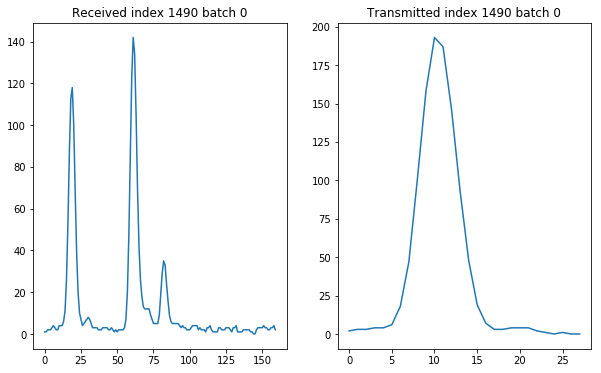

In [7]:
#plot the received and trasmitted pulses
id = ex[9]
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(otherArgs.allRecv[0][:,1,id])
plt.title('Received index {} batch 0'.format(id))
plt.subplot(1,2,2)
plt.plot(otherArgs.allTrans[0][:,0,id])
plt.title('Transmitted index {} batch 0'.format(id))

plt.show()

In [8]:
import pprint
print('waveinfo\n')
pprint.pprint(otherArgs.allWaveInfo[0][:,id].dtype.names) #['RANGE_TO_WAVEFORM_START']
print('\nheader\n')
pprint.pprint(header.keys())
print(header['NUMBER_OF_APPENDED_VARIABLE_LENGTH_RECORDS'])

waveinfo

('NUMBER_OF_WAVEFORM_RECEIVED_BINS',
 'RECEIVED_START_IDX',
 'NUMBER_OF_WAVEFORM_TRANSMITTED_BINS',
 'TRANSMITTED_START_IDX',
 'RANGE_TO_WAVEFORM_START',
 'CHANNEL',
 'RECEIVE_WAVE_GAIN',
 'RECEIVE_WAVE_OFFSET',
 'TRANS_WAVE_GAIN',
 'TRANS_WAVE_OFFSET')

header

['SYSTEM_IDENTIFIER',
 'PULSE_ATTRIBUTES',
 'FILE_CREATION_DAY',
 'HEADER_SIZE',
 'PROJECT_ID_GUID_DATA_1',
 'PROJECT_ID_GUID_DATA_3',
 'PROJECT_ID_GUID_DATA_2',
 'FILE_SOURCE_ID',
 'NUMBER_OF_VARIABLE_LENGTH_RECORDS',
 'X_MAX',
 'FILE_CREATION_YEAR',
 'GENERATING_SOFTWARE',
 'GLOBAL_PARAMETERS',
 'Y_MAX',
 'Z_MAX',
 'OFFSET_TO_PULSE_DATA',
 'Y_MIN',
 'Z_MIN',
 'PULSE_SIZE',
 'NUMBER_OF_APPENDED_VARIABLE_LENGTH_RECORDS',
 'FILE_SIGNATURE',
 'PULSE_COMPRESSION',
 'NUMBER_OF_PULSES',
 'X_MIN',
 'PULSE_FORMAT',
 'PROJECT_ID_GUID_DATA_4']
0


In [9]:
ex_wf_start = otherArgs.allWaveInfo[0][:,id]['RANGE_TO_WAVEFORM_START']
print('ex. RANGE_TO_WAVEFORM_START: {}'.format(ex_wf_start))

ex. RANGE_TO_WAVEFORM_START: [-10.003006935119629 5535.11279296875 -- --]


In [10]:
temp = otherArgs.allPulses[0][id].dtype
names = temp.names

print('info for waveform {} in batch 0'.format(id))
for n in names:
    print('{}: {}'.format(n, otherArgs.allPulses[0][id][n]))

info for waveform 1490 in batch 0
TIME: 404921256066
OFFSET: 182846
X_ORIGIN: -6483.716
Y_ORIGIN: -5227.136
Z_ORIGIN: 3008.394
X_TARGET: -6536.652
Y_TARGET: -5232.079
Z_TARGET: 2868.288
FIRST_RETURNING_SAMPLE: 5535
LAST_RETURNING_SAMPLE: 5694
DESCRIPTOR_INDEX: 2
INTENSITY: 0
WFM_START_IDX: 2991
NUMBER_OF_WAVEFORM_SAMPLES: 2
NUMBER_OF_RETURNS: 1
PTS_START_IDX: 1490


In [13]:
temp = otherArgs.allPulses[0][id].dtype
names = temp.names

for i in ex:
    print('\n\ninfo for waveform {} in batch 0\n'.format(i))
    for n in names:
        print('{}: {}'.format(n, otherArgs.allPulses[0][i][n]))



info for waveform 486 in batch 0

TIME: 404927907545
OFFSET: 58706
X_ORIGIN: -6492.935
Y_ORIGIN: -5566.203
Z_ORIGIN: 3010.783
X_TARGET: -6553.266
Y_TARGET: -5564.404
Z_TARGET: 2873.621
FIRST_RETURNING_SAMPLE: 5798
LAST_RETURNING_SAMPLE: 5957
DESCRIPTOR_INDEX: 2
INTENSITY: 0
WFM_START_IDX: 973
NUMBER_OF_WAVEFORM_SAMPLES: 2
NUMBER_OF_RETURNS: 1
PTS_START_IDX: 486


info for waveform 508 in batch 0

TIME: 404926245513
OFFSET: 61426
X_ORIGIN: -6492.278
Y_ORIGIN: -5481.356
Z_ORIGIN: 3010.607
X_TARGET: -6567.84
Y_TARGET: -5481.059
Z_TARGET: 2881.198
FIRST_RETURNING_SAMPLE: 6089
LAST_RETURNING_SAMPLE: 6248
DESCRIPTOR_INDEX: 2
INTENSITY: 0
WFM_START_IDX: 1017
NUMBER_OF_WAVEFORM_SAMPLES: 2
NUMBER_OF_RETURNS: 1
PTS_START_IDX: 508


info for waveform 633 in batch 0

TIME: 404922639022
OFFSET: 76666
X_ORIGIN: -6487.231
Y_ORIGIN: -5297.811
Z_ORIGIN: 3010.112
X_TARGET: -6550.965
Y_TARGET: -5300.521
Z_TARGET: 2874.513
FIRST_RETURNING_SAMPLE: 5711
LAST_RETURNING_SAMPLE: 5870
DESCRIPTOR_INDEX: 2
INTE

DESCRIPTOR_INDEX: 2
INTENSITY: 0
WFM_START_IDX: 14148
NUMBER_OF_WAVEFORM_SAMPLES: 2
NUMBER_OF_RETURNS: 1
PTS_START_IDX: 6910


info for waveform 7075 in batch 0

TIME: 404832740297
OFFSET: 909680
X_ORIGIN: -6470.851
Y_ORIGIN: -571.431
Z_ORIGIN: 3013.941
X_TARGET: -6522.354
Y_TARGET: -579.945
Z_TARGET: 2873.472
FIRST_RETURNING_SAMPLE: 7293
LAST_RETURNING_SAMPLE: 7452
DESCRIPTOR_INDEX: 2
INTENSITY: 0
WFM_START_IDX: 14480
NUMBER_OF_WAVEFORM_SAMPLES: 2
NUMBER_OF_RETURNS: 1
PTS_START_IDX: 7075


info for waveform 7129 in batch 0

TIME: 404840995541
OFFSET: 916640
X_ORIGIN: -6468.761
Y_ORIGIN: -986.197
Z_ORIGIN: 3015.062
X_TARGET: -6511.056
Y_TARGET: -990.456
Z_TARGET: 2871.363
FIRST_RETURNING_SAMPLE: 6415
LAST_RETURNING_SAMPLE: 6574
DESCRIPTOR_INDEX: 2
INTENSITY: 0
WFM_START_IDX: 14588
NUMBER_OF_WAVEFORM_SAMPLES: 2
NUMBER_OF_RETURNS: 1
PTS_START_IDX: 7129


info for waveform 7134 in batch 0

TIME: 404840641720
OFFSET: 917400
X_ORIGIN: -6468.851
Y_ORIGIN: -968.357
Z_ORIGIN: 3015.289
X_TARGET

OFFSET: 1868118
X_ORIGIN: -6466.331
Y_ORIGIN: -3528.59
Z_ORIGIN: 3007.095
X_TARGET: -6506.921
Y_TARGET: -3532.889
Z_TARGET: 2862.906
FIRST_RETURNING_SAMPLE: 4404
LAST_RETURNING_SAMPLE: 4563
DESCRIPTOR_INDEX: 2
INTENSITY: 0
WFM_START_IDX: 28907
NUMBER_OF_WAVEFORM_SAMPLES: 2
NUMBER_OF_RETURNS: 1
PTS_START_IDX: 13662


info for waveform 13745 in batch 0

TIME: 404886963085
OFFSET: 1881390
X_ORIGIN: -6465.583
Y_ORIGIN: -3419.718
Z_ORIGIN: 3007.886
X_TARGET: -6529.039
Y_TARGET: -3420.725
Z_TARGET: 2872.134
FIRST_RETURNING_SAMPLE: 4681
LAST_RETURNING_SAMPLE: 4840
DESCRIPTOR_INDEX: 2
INTENSITY: 0
WFM_START_IDX: 29105
NUMBER_OF_WAVEFORM_SAMPLES: 2
NUMBER_OF_RETURNS: 1
PTS_START_IDX: 13745


info for waveform 13746 in batch 0

TIME: 404886885624
OFFSET: 1881590
X_ORIGIN: -6465.535
Y_ORIGIN: -3415.493
Z_ORIGIN: 3007.978
X_TARGET: -6529.128
Y_TARGET: -3416.137
Z_TARGET: 2872.287
FIRST_RETURNING_SAMPLE: 4680
LAST_RETURNING_SAMPLE: 4839
DESCRIPTOR_INDEX: 2
INTENSITY: 0
WFM_START_IDX: 29107
NUMBER_O

LAST_RETURNING_SAMPLE: 6638
DESCRIPTOR_INDEX: 2
INTENSITY: 0
WFM_START_IDX: 41136
NUMBER_OF_WAVEFORM_SAMPLES: 2
NUMBER_OF_RETURNS: 1
PTS_START_IDX: 19071


info for waveform 19091 in batch 0

TIME: 404856828437
OFFSET: 2688482
X_ORIGIN: -6469.843
Y_ORIGIN: -1808.258
Z_ORIGIN: 3021.768
X_TARGET: -6534.23
Y_TARGET: -1806.938
Z_TARGET: 2886.457
FIRST_RETURNING_SAMPLE: 6044
LAST_RETURNING_SAMPLE: 6203
DESCRIPTOR_INDEX: 2
INTENSITY: 0
WFM_START_IDX: 41179
NUMBER_OF_WAVEFORM_SAMPLES: 2
NUMBER_OF_RETURNS: 1
PTS_START_IDX: 19091


info for waveform 19092 in batch 0

TIME: 404856684633
OFFSET: 2688682
X_ORIGIN: -6469.829
Y_ORIGIN: -1800.637
Z_ORIGIN: 3021.925
X_TARGET: -6531.661
Y_TARGET: -1799.163
Z_TARGET: 2885.43
FIRST_RETURNING_SAMPLE: 5938
LAST_RETURNING_SAMPLE: 6097
DESCRIPTOR_INDEX: 2
INTENSITY: 0
WFM_START_IDX: 41181
NUMBER_OF_WAVEFORM_SAMPLES: 2
NUMBER_OF_RETURNS: 1
PTS_START_IDX: 19092


info for waveform 19155 in batch 0

TIME: 404852977909
OFFSET: 2697614
X_ORIGIN: -6471.295
Y_ORIGI

TIME: 404797720826
OFFSET: 4118284
X_ORIGIN: -6466.595
Y_ORIGIN: 1184.099
Z_ORIGIN: 3012.845
X_TARGET: -6403.564
Y_TARGET: 1182.698
Z_TARGET: 2876.898
FIRST_RETURNING_SAMPLE: 9197
LAST_RETURNING_SAMPLE: 9356
DESCRIPTOR_INDEX: 2
INTENSITY: 0
WFM_START_IDX: 63224
NUMBER_OF_WAVEFORM_SAMPLES: 2
NUMBER_OF_RETURNS: 1
PTS_START_IDX: 29900


info for waveform 30477 in batch 0

TIME: 404791578090
OFFSET: 4193938
X_ORIGIN: -6461.266
Y_ORIGIN: 1500.204
Z_ORIGIN: 3011.942
X_TARGET: -6417.721
Y_TARGET: 1496.465
Z_TARGET: 2868.602
FIRST_RETURNING_SAMPLE: 8146
LAST_RETURNING_SAMPLE: 8305
DESCRIPTOR_INDEX: 2
INTENSITY: 0
WFM_START_IDX: 64407
NUMBER_OF_WAVEFORM_SAMPLES: 2
NUMBER_OF_RETURNS: 1
PTS_START_IDX: 30477


info for waveform 30555 in batch 0

TIME: 404788601808
OFFSET: 4204104
X_ORIGIN: -6459.278
Y_ORIGIN: 1656.138
Z_ORIGIN: 3007.761
X_TARGET: -6415.442
Y_TARGET: 1653.264
Z_TARGET: 2864.489
FIRST_RETURNING_SAMPLE: 8610
LAST_RETURNING_SAMPLE: 8769
DESCRIPTOR_INDEX: 2
INTENSITY: 0
WFM_START_IDX: 

INTENSITY: 0
WFM_START_IDX: 85438
NUMBER_OF_WAVEFORM_SAMPLES: 2
NUMBER_OF_RETURNS: 1
PTS_START_IDX: 40805


info for waveform 40831 in batch 0

TIME: 404729497948
OFFSET: 5569394
X_ORIGIN: -6452.586
Y_ORIGIN: 4799.261
Z_ORIGIN: 3013.459
X_TARGET: -6467.902
Y_TARGET: 4796.112
Z_TARGET: 2864.422
FIRST_RETURNING_SAMPLE: 6422
LAST_RETURNING_SAMPLE: 6581
DESCRIPTOR_INDEX: 2
INTENSITY: 0
WFM_START_IDX: 85491
NUMBER_OF_WAVEFORM_SAMPLES: 2
NUMBER_OF_RETURNS: 1
PTS_START_IDX: 40831


info for waveform 40851 in batch 0

TIME: 404729243914
OFFSET: 5572120
X_ORIGIN: -6452.622
Y_ORIGIN: 4812.541
Z_ORIGIN: 3013.528
X_TARGET: -6458.772
Y_TARGET: 4809.851
Z_TARGET: 2863.824
FIRST_RETURNING_SAMPLE: 6439
LAST_RETURNING_SAMPLE: 6598
DESCRIPTOR_INDEX: 2
INTENSITY: 0
WFM_START_IDX: 85532
NUMBER_OF_WAVEFORM_SAMPLES: 2
NUMBER_OF_RETURNS: 1
PTS_START_IDX: 40851


info for waveform 40861 in batch 0

TIME: 404730052737
OFFSET: 5573560
X_ORIGIN: -6452.557
Y_ORIGIN: 4770.226
Z_ORIGIN: 3013.328
X_TARGET: -6432.671

info for waveform 13759 in batch 0

NUMBER_OF_WAVEFORM_RECEIVED_BINS: [0L 160L 80L --]
RECEIVED_START_IDX: [0L 1323920L 1324080L --]
NUMBER_OF_WAVEFORM_TRANSMITTED_BINS: [28L 0L 0L --]
TRANSMITTED_START_IDX: [385252L 0L 0L --]
RANGE_TO_WAVEFORM_START: [-11.998270034790039 4353.10986328125 4354.837890625 --]
CHANNEL: [3 1 0 --]
RECEIVE_WAVE_GAIN: [1.0 1.0 1.0 --]
RECEIVE_WAVE_OFFSET: [0.0 0.0 0.0 --]
TRANS_WAVE_GAIN: [1.0 1.0 1.0 --]
TRANS_WAVE_OFFSET: [0.0 0.0 0.0 --]


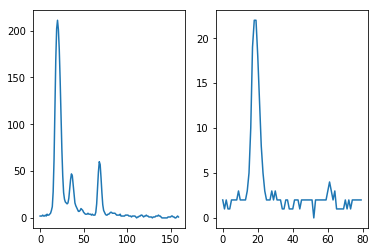

info for received waveform 13759 in batch 0



TypeError: 'NoneType' object is not iterable

In [91]:
# check out one with multiple samples, e.g. index 13759
winfo = otherArgs.allWaveInfo[0][:,13759] 
temp = winfo.dtype
names = temp.names


print('info for waveform {} in batch 0\n'.format(13759))
for n in names:
    print('{}: {}'.format(n, winfo[n]))
    
# show the waveform parts
pls = otherArgs.allPulses[0][13759]
num_rets = pls['NUMBER_OF_WAVEFORM_SAMPLES']
rcv = otherArgs.allRecv[0][:,:,13759]
for i in range(1,num_rets):
    
    plt.subplot(1,num_rets - 1, i)
    plt.plot(rcv[:,i])
    
plt.show()

temp = rcv.dtype
names = temp.names
print('info for received waveform {} in batch 0\n'.format(13759))
for n in names:
    print('{}: {}'.format(n, rcv[:,13759][n]))

In [34]:
otherArgs.allTrans[0][:,:,id].T

masked_array(data =
 [[2 3 3 4 4 6 18 47 101 158 193 187 146 93 48 19 7 3 3 4 4 4 2 1 0 1 0 0]
 [-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- -- -- --]
 [-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- -- -- --]
 [-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- -- -- --]],
             mask =
 [[False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  T

In [63]:
# find returned pulses that have more than one segment
m_seg=[]
r = otherArgs.allRecv[0].shape[-1]
for i in range(r):

    # get the relative maxima locations
    x = otherArgs.allPulses[0][i]['NUMBER_OF_WAVEFORM_SAMPLES']
        
    # this grabs the index if there are more than 2 samples. 
    # 1 sample for the Tx, up to 2 samples for the Rx
    if x > 3:
        print x
        m_seg.append(i)
        
print m_seg

4
4
4
4
4
4
4
4
4
4
[12515, 12781, 12917, 12926, 12935, 13454, 13672, 15955, 16561, 18066]


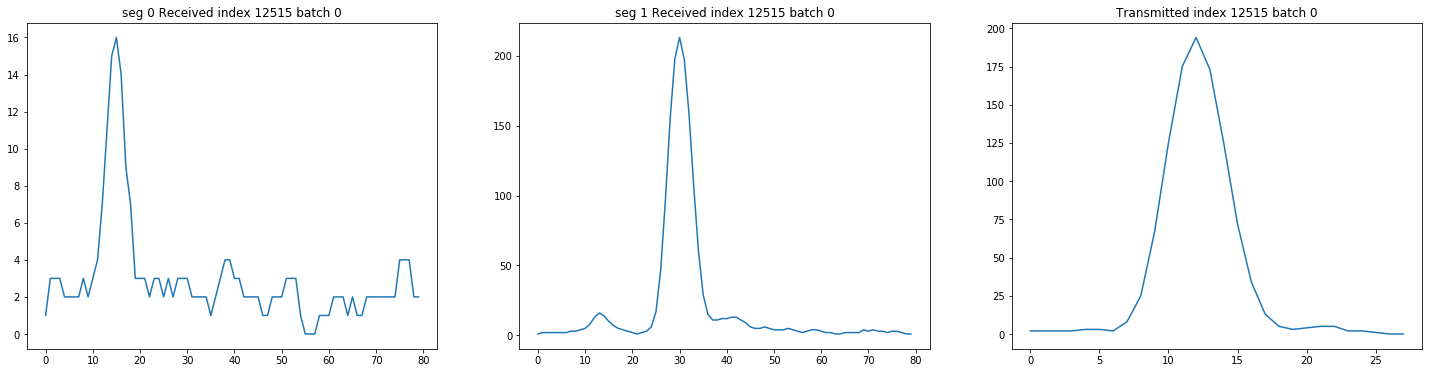

In [62]:
mseg_id = m_seg[0]
plt.figure(figsize=(25,6))
plt.subplot(1,3,1)
plt.plot(otherArgs.allRecv[0][:,2,mseg_id])
plt.title('seg 0 Received index {} batch 0'.format(mseg_id))
plt.subplot(1,3,2)
plt.plot(otherArgs.allRecv[0][:,1,mseg_id])
plt.title('seg 1 Received index {} batch 0'.format(mseg_id))
plt.subplot(1,3,3)
plt.plot(otherArgs.allTrans[0][:,0,id])
plt.title('Transmitted index {} batch 0'.format(mseg_id))

plt.show()

In [64]:
print(otherArgs.allWaveInfo[0][:,mseg_id])

[(0L, 0L, 28L, 350420L, -11.998270034790039, 3, 1.0, 0.0, 1.0, 0.0)
 (80L, 1161680L, 0L, 0L, 5073.11279296875, 1, 1.0, 0.0, 1.0, 0.0)
 (80L, 1161760L, 0L, 0L, 5161.111328125, 1, 1.0, 0.0, 1.0, 0.0)
 (80L, 1161840L, 0L, 0L, 5074.8408203125, 0, 1.0, 0.0, 1.0, 0.0)]


In [65]:
temp = otherArgs.allPulses[0][mseg_id].dtype
names = temp.names

print('info for pulse {} in batch 0'.format(mseg_id))
for n in names:
    print('{}: {}'.format(n, otherArgs.allPulses[0][mseg_id][n]))
    
temp = otherArgs.allWaveInfo[0][:,mseg_id].dtype
names = temp.names

print('\ninfo for waveform {} in batch 0'.format(mseg_id))
for n in names:
    print('{}: {}'.format(n, otherArgs.allWaveInfo[0][:,mseg_id][n]))

info for pulse 12515 in batch 0
TIME: 404883410321
OFFSET: 1668286
X_ORIGIN: -6463.194
Y_ORIGIN: -3225.254
Z_ORIGIN: 3011.477
X_TARGET: -6536.921
Y_TARGET: -3221.505
Z_TARGET: 2881.067
FIRST_RETURNING_SAMPLE: 5073
LAST_RETURNING_SAMPLE: 5240
DESCRIPTOR_INDEX: 5
INTENSITY: 0
WFM_START_IDX: 26021
NUMBER_OF_WAVEFORM_SAMPLES: 4
NUMBER_OF_RETURNS: 1
PTS_START_IDX: 12515

info for waveform 12515 in batch 0
NUMBER_OF_WAVEFORM_RECEIVED_BINS: [0L 80L 80L 80L]
RECEIVED_START_IDX: [0L 1161680L 1161760L 1161840L]
NUMBER_OF_WAVEFORM_TRANSMITTED_BINS: [28L 0L 0L 0L]
TRANSMITTED_START_IDX: [350420L 0L 0L 0L]
RANGE_TO_WAVEFORM_START: [-11.998270034790039 5073.11279296875 5161.111328125 5074.8408203125]
CHANNEL: [3 1 1 0]
RECEIVE_WAVE_GAIN: [1.0 1.0 1.0 1.0]
RECEIVE_WAVE_OFFSET: [0.0 0.0 0.0 0.0]
TRANS_WAVE_GAIN: [1.0 1.0 1.0 1.0]
TRANS_WAVE_OFFSET: [0.0 0.0 0.0 0.0]


In [66]:
header['NUMBER_OF_VARIABLE_LENGTH_RECORDS']

17L

In [67]:
header['NUMBER_OF_APPENDED_VARIABLE_LENGTH_RECORDS']

0L

In [68]:
a = otherArgs.allPulses[0][id]['FIRST_RETURNING_SAMPLE']
b = otherArgs.allPulses[0][id]['LAST_RETURNING_SAMPLE']
c = b-a
print(c)

a = otherArgs.allPulses[0][mseg_id]['FIRST_RETURNING_SAMPLE']
b = otherArgs.allPulses[0][mseg_id]['LAST_RETURNING_SAMPLE']
c = b-a
print(c)

167
167


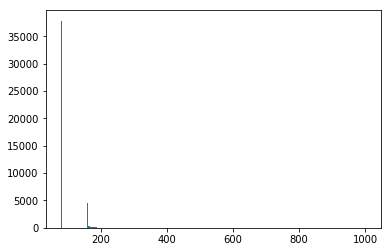

In [69]:
# this looks like the duration
durations = [p['LAST_RETURNING_SAMPLE'] - p['FIRST_RETURNING_SAMPLE'] for p in otherArgs.allPulses[0]]

plt.hist(durations, bins=255)
plt.show()

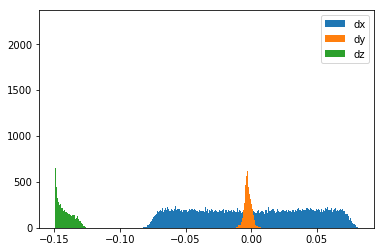

In [70]:
# plot the unit vector distribution
dx = [(p['X_TARGET'] - p['X_ORIGIN']) / 1000 for p in otherArgs.allPulses[0]]
dy = [(p['Y_TARGET'] - p['Y_ORIGIN']) / 1000 for p in otherArgs.allPulses[0]]
dz = [(p['Z_TARGET'] - p['Z_ORIGIN']) / 1000 for p in otherArgs.allPulses[0]]

plt.hist(dx, bins=255, label='dx')
plt.hist(dy, bins=255, label='dy')
plt.hist(dz, bins=255, label='dz')
plt.legend()
plt.show()

In [71]:
# get the first returning sample
x_first = [p['X_ORIGIN'] + p['FIRST_RETURNING_SAMPLE']*dx[i] for i,p in enumerate(otherArgs.allPulses[0])]
y_first = [p['Y_ORIGIN'] + p['FIRST_RETURNING_SAMPLE']*dy[i] for i,p in enumerate(otherArgs.allPulses[0])]
z_first = [p['Z_ORIGIN'] + p['FIRST_RETURNING_SAMPLE']*dz[i] for i,p in enumerate(otherArgs.allPulses[0])]

# get the last returning sample
x_last = [p['X_ORIGIN'] + p['LAST_RETURNING_SAMPLE']*dx[i] for i,p in enumerate(otherArgs.allPulses[0])]
y_last = [p['Y_ORIGIN'] + p['LAST_RETURNING_SAMPLE']*dy[i] for i,p in enumerate(otherArgs.allPulses[0])]
z_last = [p['Z_ORIGIN'] + p['LAST_RETURNING_SAMPLE']*dz[i] for i,p in enumerate(otherArgs.allPulses[0])]


X_LAST: -6849.52348
X_FIRST: -6837.211071
Y_LAST: -3205.60924
Y_FIRST: -3206.235323
Z_LAST: 2328.1286
Z_FIRST: 2349.90707
Segments: 4.      (if 2, one Tx, one Rx)
seg 1 len: 80 (masked)
seg 1 len: 240 (unmasked)
seg 2 len: 80 (masked)
seg 2 len: 240 (unmasked)
seg 3 len: 80 (masked)
seg 3 len: 240 (unmasked)


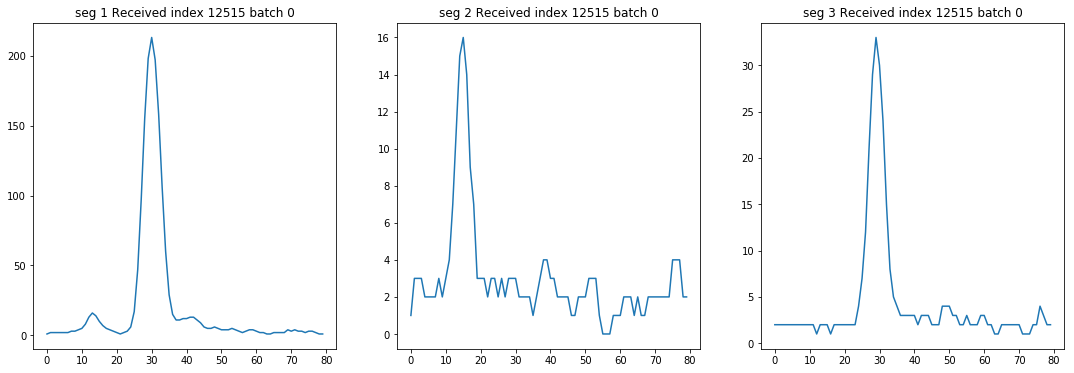

info for pulse 12515 in batch 0
TIME: 404883410321
OFFSET: 1668286
X_ORIGIN: -6463.194
Y_ORIGIN: -3225.254
Z_ORIGIN: 3011.477
X_TARGET: -6536.921
Y_TARGET: -3221.505
Z_TARGET: 2881.067
FIRST_RETURNING_SAMPLE: 5073
LAST_RETURNING_SAMPLE: 5240
DESCRIPTOR_INDEX: 5
INTENSITY: 0
WFM_START_IDX: 26021
NUMBER_OF_WAVEFORM_SAMPLES: 4
NUMBER_OF_RETURNS: 1
PTS_START_IDX: 12515

info for waveform 12515 in batch 0
NUMBER_OF_WAVEFORM_RECEIVED_BINS: [0L 80L 80L 80L]
RECEIVED_START_IDX: [0L 1161680L 1161760L 1161840L]
NUMBER_OF_WAVEFORM_TRANSMITTED_BINS: [28L 0L 0L 0L]
TRANSMITTED_START_IDX: [350420L 0L 0L 0L]
RANGE_TO_WAVEFORM_START: [-11.998270034790039 5073.11279296875 5161.111328125 5074.8408203125]
CHANNEL: [3 1 1 0]
RECEIVE_WAVE_GAIN: [1.0 1.0 1.0 1.0]
RECEIVE_WAVE_OFFSET: [0.0 0.0 0.0 0.0]
TRANS_WAVE_GAIN: [1.0 1.0 1.0 1.0]
TRANS_WAVE_OFFSET: [0.0 0.0 0.0 0.0]


In [89]:
id = mseg_id
print('X_LAST: {}'.format(x_last[id]))
print('X_FIRST: {}'.format(x_first[id]))
print('Y_LAST: {}'.format(y_last[id]))
print('Y_FIRST: {}'.format(y_first[id]))
print('Z_LAST: {}'.format(z_last[id]))
print('Z_FIRST: {}'.format(z_first[id]))
print('Segments: {}.      (if 2, one Tx, one Rx)'.format(otherArgs.allPulses[0][id]['NUMBER_OF_WAVEFORM_SAMPLES']))
#print('Duration: {}'.format(durations[id]))

if otherArgs.allPulses[0][id]['NUMBER_OF_WAVEFORM_SAMPLES']>2:
    for i in range(1, otherArgs.allPulses[0][id]['NUMBER_OF_WAVEFORM_SAMPLES']):
        seg_masked_len = otherArgs.allRecv[0][:,i,id].count()
        seg_len = otherArgs.allRecv[0][:,i,id].size
        print('seg {} len: {} (masked)'.format(i,seg_masked_len))
        print('seg {} len: {} (unmasked)'.format(i,seg_len))
    
    
#     seg0_masked_len = otherArgs.allRecv[0][:,1,id].count()
#     seg1_masked_len = otherArgs.allRecv[0][:,2,id].count()
#     seg0_len = otherArgs.allRecv[0][:,1,id].size
#     seg1_len = otherArgs.allRecv[0][:,2,id].size
#     print('seg0 len: {} (masked)'.format(seg0_masked_len))
#     print('seg1 len: {} (masked)'.format(seg1_masked_len))
#     print('seg0 len: {} (unmasked)'.format(seg0_len))
#     print('seg1 len: {} (unmasked)'.format(seg1_len))
    
    
plot = True
if plot:
    plt.figure(figsize=(25,6))
    for i in range(1, otherArgs.allPulses[0][id]['NUMBER_OF_WAVEFORM_SAMPLES']):
        plt.subplot(1,otherArgs.allPulses[0][id]['NUMBER_OF_WAVEFORM_SAMPLES'],i)
        seg = otherArgs.allRecv[0][:,i,id]
        plt.plot(seg)
        plt.title('seg {} Received index {} batch 0'.format(i,id))
        
#     seg0 = otherArgs.allRecv[0][:,1,id]
#     seg1 = otherArgs.allRecv[0][:,2,id]
#     tx = otherArgs.allTrans[0][:,0,id]
#     plt.figure(figsize=(25,6))
#     plt.subplot(1,3,1)
#     plt.plot(seg0)
#     plt.title('seg 0 Received index {} batch 0'.format(id))
#     plt.subplot(1,3,2)
#     plt.plot(seg1)
#     plt.title('seg 1 Received index {} batch 0'.format(id))
#     plt.subplot(1,3,3)
#     plt.plot(tx)
#     plt.title('Transmitted index {} batch 0'.format(id))

    plt.show()

temp = otherArgs.allPulses[0][id].dtype
names = temp.names

print('info for pulse {} in batch 0'.format(id))
for n in names:
    print('{}: {}'.format(n, otherArgs.allPulses[0][id][n]))
    
temp = otherArgs.allWaveInfo[0][:,id].dtype
names = temp.names

print('\ninfo for waveform {} in batch 0'.format(id))
for n in names:
    print('{}: {}'.format(n, otherArgs.allWaveInfo[0][:,id][n]))

In [46]:
# duration?
otherArgs.allWaveInfo[0][:,id]['RECEIVED_START_IDX'] 

masked_array(data = [0L 1161680L 1161760L 1161840L],
             mask = [False False False False],
       fill_value = 999999)

In [47]:
# duration is above minus this?
otherArgs.allWaveInfo[0][:,id]['TRANSMITTED_START_IDX']

masked_array(data = [350420L 0L 0L 0L],
             mask = [False False False False],
       fill_value = 999999)

In [48]:
print(otherArgs.allWaveInfo[0][:,id]['NUMBER_OF_WAVEFORM_RECEIVED_BINS'])
print(otherArgs.allWaveInfo[0][:,id]['NUMBER_OF_WAVEFORM_TRANSMITTED_BINS'])

[0L 80L 80L 80L]
[28L 0L 0L 0L]


In [49]:
otherArgs.allWaveInfo[0][:,id]['RANGE_TO_WAVEFORM_START']

masked_array(data = [-11.998270034790039 5073.11279296875 5161.111328125 5074.8408203125],
             mask = [False False False False],
       fill_value = 1e+20)

In [50]:
lrs = otherArgs.allPulses[0][id]['LAST_RETURNING_SAMPLE']
frs = otherArgs.allPulses[0][id]['FIRST_RETURNING_SAMPLE']

print('Last Returning Sample: {}'.format(lrs))
print('First Returning Sample: {}'.format(frs))
print('duration: {}'.format(lrs-frs))
print('First Returning Sample matches first segment RANGE_TO_WAVEFORM_START')

Last Returning Sample: 5240
First Returning Sample: 5073
duration: 167
First Returning Sample matches first segment RANGE_TO_WAVEFORM_START


In [51]:
print('x first: {}'.format(x_first[id]))
print('y first: {}'.format(y_first[id]))
print('z first: {}'.format(z_first[id]))

print('')
print('x last: {}'.format(x_last[id]))
print('y last: {}'.format(y_last[id]))
print('z last: {}'.format(z_last[id]))
print('')

print('The last xyz coordinate is for the last return in seg1 (or seg0 if appropriate)')

x first: -6837.211071
y first: -3206.235323
z first: 2349.90707

x last: -6849.52348
y last: -3205.60924
z last: 2328.1286

The last xyz coordinate is for the last return in seg1 (or seg0 if appropriate)


In [52]:
def stack_waveform(recv, trans, winfo, pulse):
    
    # get the returned waveform segments
    seg0 = recv[:,1].compressed()
    seg1 = recv[:,2].compressed()
    
    # get the last and first returning sample
    lrs = pulse['LAST_RETURNING_SAMPLE']
    frs = pulse['FIRST_RETURNING_SAMPLE']
    
    # use those samples to get the duration
    dur = lrs - frs
    
    # get the number of bins per segment
    recv_bins = winfo['NUMBER_OF_WAVEFORM_RECEIVED_BINS']
    seg0_bins = recv_bins[1]
    seg1_bins = recv_bins[2]
    
#     a = first returning sample + seg0bins 
#     b = last returning sample - seg1bins
#     pad = b-a
    # get the number of bins to place between segments (dead time)
    dead_zone = (lrs - seg1_bins) - (frs + seg0_bins)
    dead_arr = np.zeros((dead_zone,))
    segs = [seg0, dead_arr, seg1]
    
    return(np.hstack(segs))
    
    
    

In [53]:
test_recv, test_trans, test_winfo, test_pulse = otherArgs.allRecv[0][:,:,id], \
                                                otherArgs.allTrans[0][:,:,id], \
                                                otherArgs.allWaveInfo[0][:,id], \
                                                otherArgs.allPulses[0][id]
a = stack_waveform(test_recv, test_trans, test_winfo, test_pulse)
print(a.shape)

(167L,)


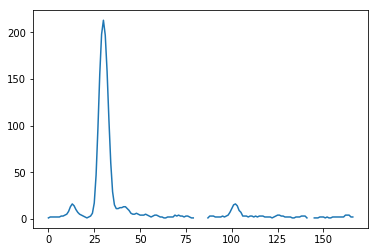

masked_array(data = [1.0 2.0 2.0 2.0 2.0 2.0 2.0 3.0 3.0 4.0 5.0 8.0 13.0 16.0 14.0 10.0 7.0
 5.0 4.0 3.0 2.0 1.0 2.0 3.0 6.0 17.0 47.0 97.0 155.0 198.0 213.0 197.0
 158.0 106.0 60.0 29.0 15.0 11.0 11.0 12.0 12.0 13.0 13.0 11.0 9.0 6.0 5.0
 5.0 6.0 5.0 4.0 4.0 4.0 5.0 4.0 3.0 2.0 3.0 4.0 4.0 3.0 2.0 2.0 1.0 1.0
 2.0 2.0 2.0 2.0 4.0 3.0 4.0 3.0 3.0 2.0 3.0 3.0 2.0 1.0 1.0 -- -- -- -- --
 -- -- 1.0 3.0 3.0 3.0 2.0 2.0 2.0 2.0 3.0 2.0 3.0 4.0 7.0 11.0 15.0 16.0
 14.0 9.0 7.0 3.0 3.0 3.0 2.0 3.0 3.0 2.0 3.0 2.0 3.0 3.0 3.0 2.0 2.0 2.0
 2.0 1.0 2.0 3.0 4.0 4.0 3.0 3.0 2.0 2.0 2.0 2.0 1.0 1.0 2.0 2.0 2.0 3.0
 3.0 3.0 1.0 -- -- -- 1.0 1.0 1.0 2.0 2.0 2.0 1.0 2.0 1.0 1.0 2.0 2.0 2.0
 2.0 2.0 2.0 2.0 4.0 4.0 4.0 2.0 2.0],
             mask = [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False F

In [54]:
b = np.ma.masked_equal(a, 0)
plt.plot(b)
plt.show()
b

In [55]:
# find returned pulses that have more than one segment
m_seg_all=[]
r = otherArgs.allRecv[0].shape[-1]
for i in range(r):

    # get the relative maxima locations
    x = otherArgs.allPulses[0][i]['NUMBER_OF_WAVEFORM_SAMPLES']
        
    # this grabs the index if there are more than 2 samples. 
    # 1 sample for the Tx, up to 2 samples for the Rx
    if x > 2:
        m_seg_all.append(x)
        
#print m_seg

In [56]:
arr = np.array(m_seg_all)
np.where(arr==4)

(array([ 991, 1138, 1199, 1205, 1212, 1499, 1581, 2326, 2497, 2752], dtype=int64),)

In [57]:
test_winfo['NUMBER_OF_WAVEFORM_RECEIVED_BINS']

masked_array(data = [0L 80L 80L 80L],
             mask = [False False False False],
       fill_value = 999999)

In [58]:
def stack_waveform_gen(recv, trans, winfo, pulse):
    
    # determine number of waveform segments:
    num_segs = pulse['NUMBER_OF_WAVEFORM_SAMPLES'] - 1
    
    segs = {}
    # get the returned waveform segments
    for s in range(num_segs):
        segs['seg{}'.format(s)] = recv[:, s+1].compressed
        #seg0 = recv[:,1].compressed()
        #seg1 = recv[:,2].compressed()
    
    # get the last and first returning sample
    lrs = pulse['LAST_RETURNING_SAMPLE']
    frs = pulse['FIRST_RETURNING_SAMPLE']
    
    # use those samples to get the duration
    dur = lrs - frs
    
    # get the number of bins per segment
    recv_bins = winfo['NUMBER_OF_WAVEFORM_RECEIVED_BINS']
    seg_bins={}
    for s in range(num_segs):
        seg_bins['seg_bins{}'.format(s)] = recv_bins[s+1]
        #seg0_bins = recv_bins[1]
        #seg1_bins = recv_bins[2]
    
#     a = first returning sample + seg0bins 
#     b = last returning sample - seg1bins
#     pad = b-a
    # get the number of bins to place between segments (dead time)
    # multiple 'dead zones'
    # iterate over number of dead zones
    num_dead_zones = num_segs - 1
    for i in range(num_dead_zones):
        
    
    dead_zone = (lrs - seg1_bins) - (frs + seg0_bins)
    dead_arr = np.zeros((dead_zone,))
    segs = [seg0, dead_arr, seg1]
    
    return(np.hstack(segs))

IndentationError: expected an indented block (<ipython-input-58-3f6e872a8631>, line 38)

In [ ]:
durations[id]
test_pulse['LAST_RETURNING_SAMPLE'] - test_pulse['FIRST_RETURNING_SAMPLE']


In [ ]:
print 'pulse fields'
for n in test_pulse.dtype.names:
    print('{}: {}'.format(n, test_pulse[n]))


print('\nwaveform info')
for n in test_winfo.dtype.names:
    print('{}: {}'.format(n, test_winfo[n]))

In [ ]:
test_pulse['DESCRIPTOR_INDEX']
test_pulse['WFM_START_IDX']


In [ ]:
print('sample duration:')
print(test_pulse['LAST_RETURNING_SAMPLE'] - test_pulse['FIRST_RETURNING_SAMPLE'])
plt.figure(figsize=[25,6])
plt.subplot(1,3,1)
plt.plot(test_recv[:,1])
plt.subplot(1,3,2)
plt.plot(test_recv[:,2])
plt.subplot(1,3,3)
plt.plot(test_recv[:,3])
plt.show()

In [ ]:
otherArgs.transDict